## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Uploading the given dataset file 

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/')

Extracting all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile('train.zip', 'r') as z:
  z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile('test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile('sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile('labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/labels.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/sample_submission.csv')

In [7]:
# display data labes
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
df.shape

(10222, 2)

### Print the count of each category of Dogs given in the dataset



In [0]:
from tqdm import tqdm
import cv2

In [0]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [11]:
print("No of training sample is" ,n)
print("No of breeds", len(breed))

No of training sample is 10222
No of breeds 120


In [0]:
import seaborn as sns

In [13]:
df.pivot_table(index="breed", aggfunc=len).sort_values("id", ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Distribution of Dog breeds')

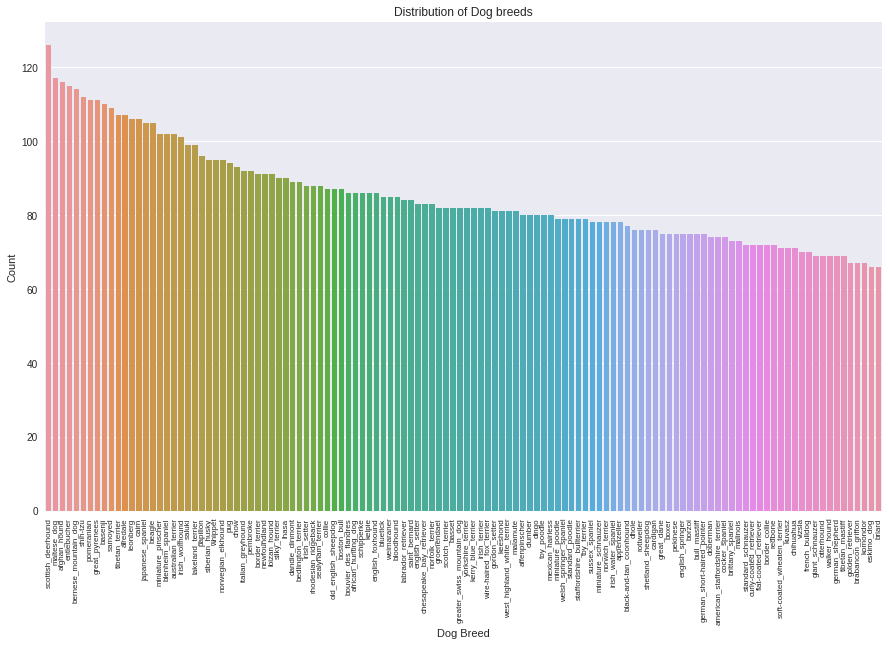

In [14]:
yy = pd.value_counts(df['breed'])

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of Dog breeds')

### Get one-hot encodings of labels

In [0]:
one_hot = pd.get_dummies(df['breed'], sparse = True)
one_hot_labels = np.asarray(one_hot) 

In [16]:
one_hot_labels.shape

(10222, 120)

## Preparing training dataset
1. Writing a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Creating 2 variables <br> 
     a.  x_train - Has all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>

In [0]:
# load train images 

width = 128
X_train = np.zeros((n, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n, n_class), dtype=np.uint8)

for i in tqdm(range(n)): 
  try:
      X_train[i] = cv2.resize(cv2.imread('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/train/%s.jpg' % df['id'][i]), (width, width))
      y_train[i][class_to_num[df['breed'][i]]] = 1

  except Exception as e:
      print(str(e))


In [0]:
# saving the loaded dataset using pickle for future usage
import pickle

with open('DogBreedtrain.pickle', 'wb') as f:
    pickle.dump([X_train, y_train], f)

In [0]:
import pickle

In [0]:
with open('DogBreedtrain.pickle', 'rb') as f:
    X_train, y_train = pickle.load(f)

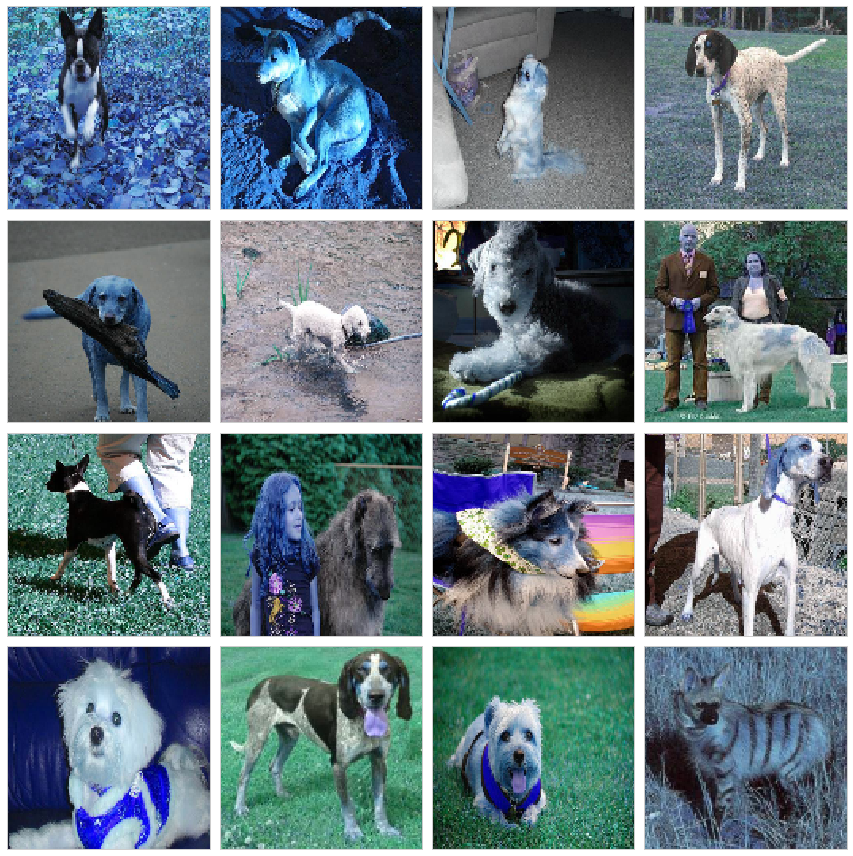

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
plotImages(X_train[0:16,]/255.)

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [20]:
X_train = X_train.astype('float32')

#Normalizing the input
X_train /= 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


x_train shape: (10222, 128, 128, 3)
10222 train samples


In [21]:
y_train[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

### Splitting the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [22]:
from sklearn.model_selection import train_test_split

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train, y_train, test_size=0.2, random_state=2)
print ("No. of images in train dataset: ", len(X_train_s))
print ("No. of images in Validation dataset: ", len(X_val_s))

No. of images in train dataset:  8177
No. of images in Validation dataset:  2045


In [23]:
print("shape of X_train",X_train.shape)
print("shape of Y_train",y_train.shape)

shape of X_train (10222, 128, 128, 3)
shape of Y_train (10222, 120)


### Loading the test data
Reading the id column from the samples_submission.csv and store it in test_img

In [0]:
test_img = df_test['id']

In [25]:
test_img.head()

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

In [26]:
df_test.shape

(10357, 121)

Running the below code to load the test image files in x_test_feature

In [0]:
width = 128
n_test = len(df_test)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/test/%s.jpg' % df_test['id'][i]), (width, width))

100%|██████████| 10357/10357 [45:09<00:00,  4.11it/s]


In [0]:
with open('DogBreedtest.pickle', 'wb') as f:
    pickle.dump([X_test], f)

In [0]:
with open('DogBreedtest.pickle', 'rb') as f:
    X_test = pickle.load(f)

Normalize the test data and convert it into 4 dimensions

In [0]:
X_test_arr = np.asarray(X_test)
X_test_std = X_test_arr/255

In [0]:
X_test_std = X_test_std.reshape(X_test_std.shape[1], 128, 128, 3).astype('float32')

In [30]:
X_test_std[10]

array([[[0.3529412 , 0.4392157 , 0.4862745 ],
        [0.32156864, 0.40392157, 0.44705883],
        [0.36862746, 0.44705883, 0.47843137],
        ...,
        [0.5019608 , 0.5294118 , 0.57254905],
        [0.38039216, 0.42745098, 0.46666667],
        [0.28235295, 0.34901962, 0.3882353 ]],

       [[0.4509804 , 0.58431375, 0.6431373 ],
        [0.4862745 , 0.62352943, 0.6784314 ],
        [0.43529412, 0.5647059 , 0.6156863 ],
        ...,
        [0.25490198, 0.33333334, 0.3647059 ],
        [0.14901961, 0.21568628, 0.2509804 ],
        [0.14901961, 0.16078432, 0.1882353 ]],

       [[0.32941177, 0.4117647 , 0.48235294],
        [0.2901961 , 0.37254903, 0.44313726],
        [0.1882353 , 0.26666668, 0.3254902 ],
        ...,
        [0.5254902 , 0.6392157 , 0.6745098 ],
        [0.23921569, 0.32941177, 0.3647059 ],
        [0.15294118, 0.18431373, 0.20392157]],

       ...,

       [[0.5803922 , 0.5803922 , 0.56078434],
        [0.50980395, 0.5019608 , 0.48235294],
        [0.50980395, 0

### Building a basic conv neural network with 2 conv layers 

1. Adding a Dense layer with 256 neurons with `relu` activation

2. Adding a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
batch_size = 128
num_classes = 120
epochs = 10

In [0]:
import tensorflow

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Dense, Flatten, Input
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization

In [34]:
#Initialize the model
model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(128,128,3),name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (3, 3), activation='relu',name='conv_2'))


#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(256, activation='relu',name='dense_1'))


#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(num_classes, activation='softmax',name='dense_2'))

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv_2 (Conv2D)              (None, 122, 122, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 952576)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               243859712 
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 243,911,480
Trainable params: 243,911,480
Non-trainable params: 0
_________________________________________________________________


### Using batch_size = 128 and epochs = 10 and executing the model

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.01)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])


In [38]:
model.fit(X_train_s, y_train_s,
                    epochs=10, 
                    validation_data=(X_val_s, y_val_s),
                    verbose = 1,
                    batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 63s 8ms/step - loss: 15.8264 - acc: 0.0071 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 2/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.9900 - acc: 0.0079 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 3/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.9900 - acc: 0.0079 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 4/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.9900 - acc: 0.0079 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 5/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.9900 - acc: 0.0079 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 6/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.9900 - acc: 0.0079 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 7/10
8177/8177 [==============================] - 49s 6ms/step - loss: 15.99

#The model accuracy is very poor !!!!

### Using Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as k
k.set_image_dim_ordering('th')

In [0]:
train_datagen = ImageDataGenerator( rotation_range=90, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

train_datagen.fit(X_train_s)

In [0]:
val_datagen = ImageDataGenerator( rotation_range=90, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

val_datagen.fit(X_val_s)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_datagen.flow(X_train_s, y_train_s, batch_size=9)
val_generator = val_datagen.flow(X_val_s, y_val_s, batch_size=9)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [47]:
model.fit_generator(train_generator,epochs=10, steps_per_epoch=300,verbose=1,validation_data=val_generator, validation_steps = 300)

Epoch 1/10
300/300 [==============================] - 128s 428ms/step - loss: 15.9689 - acc: 0.0093 - val_loss: 15.9864 - val_acc: 0.0082
Epoch 2/10
300/300 [==============================] - 128s 427ms/step - loss: 15.9450 - acc: 0.0107 - val_loss: 16.0044 - val_acc: 0.0071
Epoch 3/10
300/300 [==============================] - 128s 427ms/step - loss: 16.0524 - acc: 0.0041 - val_loss: 15.9864 - val_acc: 0.0082
Epoch 4/10
300/300 [==============================] - 128s 427ms/step - loss: 15.9927 - acc: 0.0078 - val_loss: 16.0041 - val_acc: 0.0071
Epoch 5/10
300/300 [==============================] - 129s 428ms/step - loss: 15.9808 - acc: 0.0085 - val_loss: 15.9804 - val_acc: 0.0085
Epoch 6/10
300/300 [==============================] - 128s 427ms/step - loss: 15.9927 - acc: 0.0078 - val_loss: 15.9864 - val_acc: 0.0082
Epoch 7/10
300/300 [==============================] - 128s 426ms/step - loss: 15.9868 - acc: 0.0081 - val_loss: 16.0041 - val_acc: 0.0071
Epoch 8/10
300/300 [==============

# Model accuracy is still poor!!!

### Using Transfer Learning

Using the below code to load VGG16 weights trained on ImageNet

In [0]:
import keras.backend as k
k.set_image_dim_ordering('th')

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('/content/drive/My Drive/Colab Notebooks/DogBreed_Classification/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Priningst the summary of the base_model

In [56]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

### Adding the following classification layers to the imported VGG Model <br>
1. Flattening Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [59]:
#Create input format
input = Input(shape=(3, 128, 128),name = 'image_input')

#Use generated model 
output_vgg16_conv = base_model(input)

x = Dense(units=1024, activation = 'relu')(output_vgg16_conv)
x = Dense(units=256, activation = 'relu')(x)
o = Dense(units = 120, activation = 'softmax')(x)
model = Model(input=input, output=[o])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=[<tf.Tenso...)`
  if __name__ == '__main__':


In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 3, 128, 128)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 120)               30840     
Total params: 15,533,240
Trainable params: 15,533,240
Non-trainable params: 0
_________________________________________________________________


### Making all the layers in the base_model (VGG16) to be non-trainable

In [62]:
#Freezing layers in the model 
for layer in model.layers:
  if('vgg16' in layer.name): 
    #Freezing a layer
    layer.trainable = False

    
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

image_input
False
vgg16
False
dense_4
True
dense_5
True
dense_6
True


### Fitting and compile the model with batch_size = 128 and epochs = 10 and execute the model

Trying to get training and validation accuracy to be more than 90%

In [0]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [0]:
X_train_s_th = np.rollaxis(X_train_s, 3, 1)  
X_val_s_th =  np.rollaxis(X_val_s, 3, 1)  

In [66]:
model.fit(X_train_s_th, y_train_s,epochs=10, validation_data=(X_val_s_th, y_val_s),verbose = 1,batch_size=128)

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 45s 6ms/step - loss: 4.7396 - acc: 0.0205 - val_loss: 4.6057 - val_acc: 0.0381
Epoch 2/10
8177/8177 [==============================] - 33s 4ms/step - loss: 4.3120 - acc: 0.0753 - val_loss: 4.0981 - val_acc: 0.0748
Epoch 3/10
8177/8177 [==============================] - 33s 4ms/step - loss: 3.7709 - acc: 0.1261 - val_loss: 3.7731 - val_acc: 0.1330
Epoch 4/10
8177/8177 [==============================] - 33s 4ms/step - loss: 3.4140 - acc: 0.1815 - val_loss: 3.5403 - val_acc: 0.1584
Epoch 5/10
8177/8177 [==============================] - 33s 4ms/step - loss: 3.1834 - acc: 0.2247 - val_loss: 3.4200 - val_acc: 0.1770
Epoch 6/10
8177/8177 [==============================] - 33s 4ms/step - loss: 3.0141 - acc: 0.2530 - val_loss: 3.3722 - val_acc: 0.1853
Epoch 7/10
8177/8177 [==============================] - 33s 4ms/step - loss: 2.9138 - acc: 0.2759 - val_loss: 3.3038 - val_acc: 0.2044
Epoch 8